### Construction of B-Spline Basis Functions

B-Spline Basis Functions are a computationally efficient and equivalent representation of continous piecewise polynomials, commonly known as Splines. These are defined recursively as

$$B_{i,0}(x) = \begin{cases} 1 & \text{if } x_i \leq x < x_{i+1} \\ 0 & \text{otherwise} \end{cases}$$

$$B_{i,k}(x) = \frac{x-x_i}{x_{i+k}-x_i}B_{i,k-1}(x) + \frac{x_{i+k+1}-x}{x_{i+k+1}-x_{i+1}}B_{i+1,k-1}(x)$$

where $x_i$ and $x_{i+1}$ are the knots of the spline. The $B_{i,k}$ are called B-Spline Basis Functions of degree $k$.

In [1]:
import sys
sys.path.append("../../estimators/splines/")
sys.path.append("../../basis/")

import numpy as np
from matplotlib import pyplot as plt
from b_spline_basis import B_Spline_Basis
from regression_spline_estimator import Regression_Spline_Estimator

### Let's generate some data and equally spaced knots

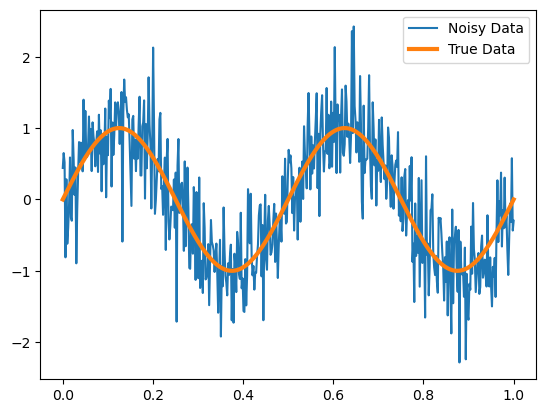

In [2]:
x=np.linspace(0,1,500)
y=np.sin(4*np.pi*x)
derivative=4*np.pi*np.cos(4*np.pi*x)
double_derivative=-16*np.pi**2*np.sin(4*np.pi*x)
noisy=y+np.random.normal(0,0.5,500)
gamma=np.linspace(0.2,0.8,10)
gamma_eval=np.sin(4*np.pi*gamma)
plt.plot(x,noisy, label='Noisy Data')
plt.plot(x,y, label='True Data',lw=3)
#plt.plot(x,derivative, label='True Derivative',lw=3)
#plt.plot(x,double_derivative, label='True Double Derivative',lw=3)
plt.legend()



In [3]:
print(f"Knots = {gamma}")

Knots = [0.2        0.26666667 0.33333333 0.4        0.46666667 0.53333333
 0.6        0.66666667 0.73333333 0.8       ]


### Initiate an instance of B-Spline Basis Functions

Here the B-spline basis functions are callable given a set of design points. The basis functions are evaluated at the design points and the resulting matrix is returned which is shape N x (K+M)

In [4]:
basis=B_Spline_Basis(x,gamma,degree=3)

In [5]:
gamma

array([0.2       , 0.26666667, 0.33333333, 0.4       , 0.46666667,
       0.53333333, 0.6       , 0.66666667, 0.73333333, 0.8       ])

In [6]:
eval_basis=basis.B(x,m=4)
eval_basis.shape

(500, 14)

### Visualize the density of our matrix

In general this design matrix is of the size N x (K+M) where N is the number of observations, K is the size of the knot vector and M is the degree of the spline. 

The number of columns is the number of basis functions. The number of rows is the number of observations. 

In the case of smoothing splines; this simplifies to N x (N+4)

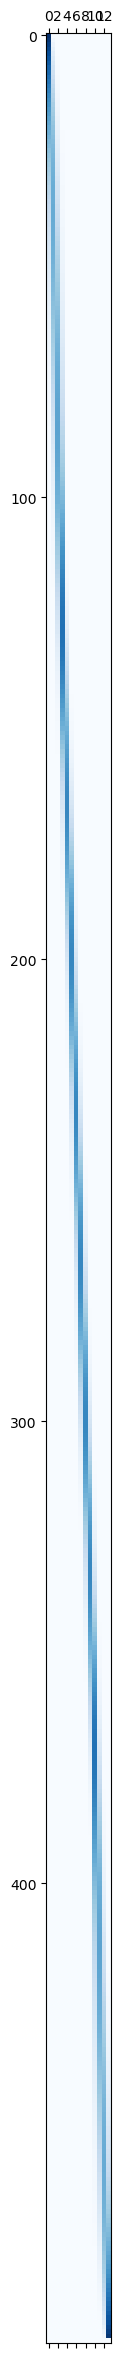

In [7]:
fig,ax=plt.subplots(1,1,figsize=(12,30))

ax.matshow(eval_basis, cmap=plt.cm.Blues)

Note the above is a banded matrix which we can take advantage of when inverting. Applying the cholesky decomposition to the matrix is computationally efficient. We can then solve for the remaining linear system

In [8]:
regularized_basis=eval_basis.T@eval_basis+np.eye(eval_basis.shape[1])*0.01

L=np.linalg.cholesky(regularized_basis)
LT=L.T

beta=np.linalg.solve(L@LT,eval_basis.T@noisy)
beta.shape



(14,)

### Solve for the solution vector and visualize the basis functions

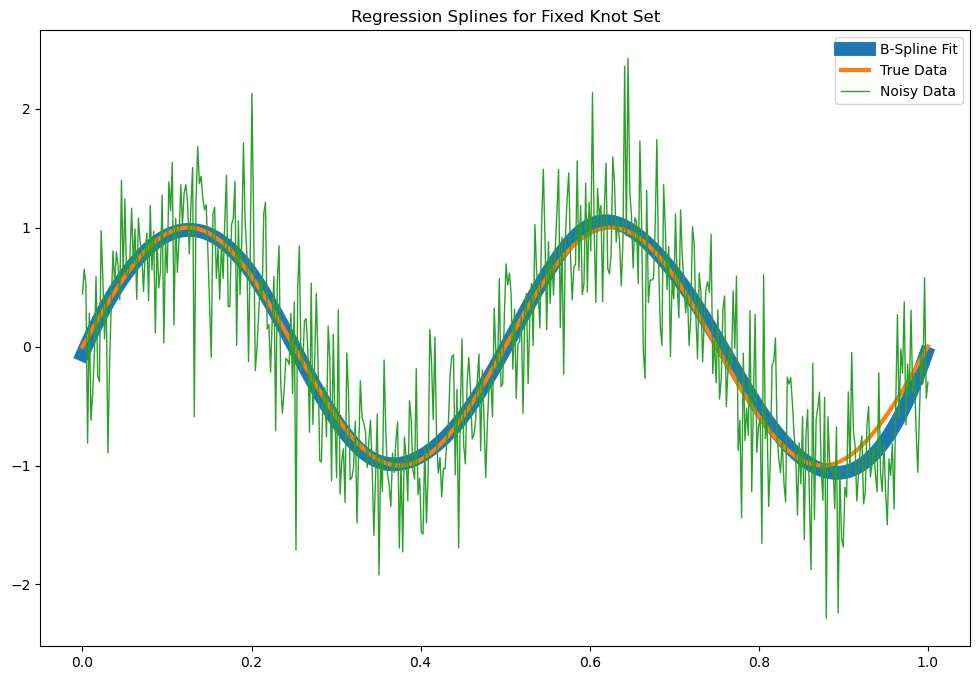

In [9]:
fig,ax=plt.subplots(1,1,figsize=(12,8))

ax.set_title('Regression Splines for Fixed Knot Set')

ax.plot(x[:-1],basis.B(x[:-1],m=4)@beta, label='B-Spline Fit',lw=10)

ax.plot(x,y, label='True Data',lw=3)
ax.plot(x,noisy, label='Noisy Data',lw=1)

ax.legend()

### Regression Spline Estimator

In [10]:
spline=Regression_Spline_Estimator(x,noisy,gamma,degree=3,lambda_=0.1)

In [11]:
estimate=spline.fit()[1]

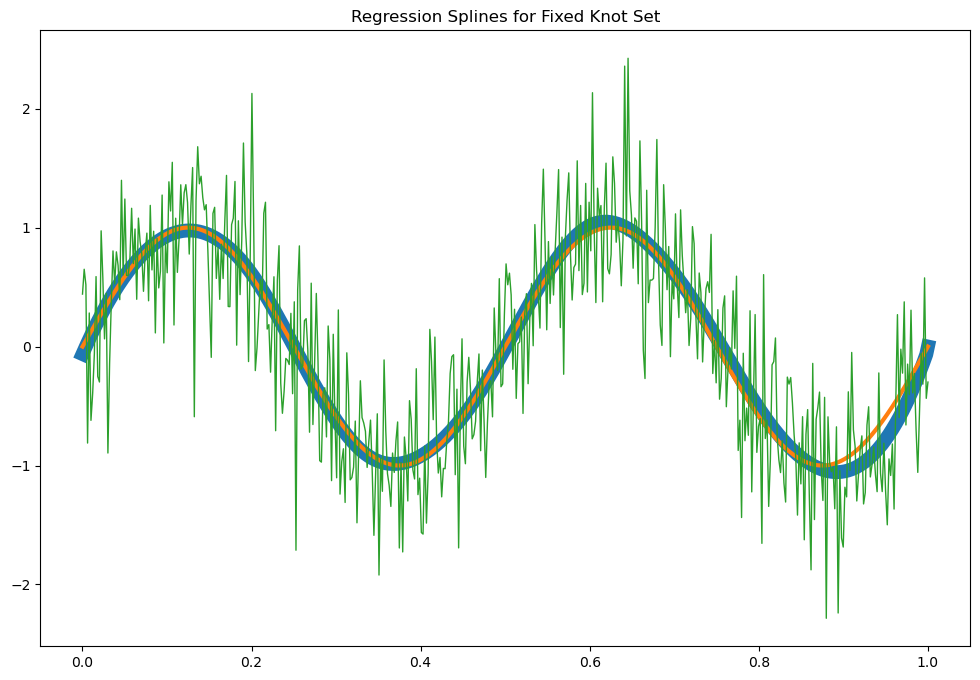

In [12]:
fig,ax=plt.subplots(1,1,figsize=(12,8))

ax.set_title('Regression Splines for Fixed Knot Set')

ax.plot(x,estimate, label='B-Spline Fit',lw=10)

ax.plot(x,y, label='True Data',lw=3)
ax.plot(x,noisy, label='Noisy Data',lw=1)


### Arbitrary Prediction

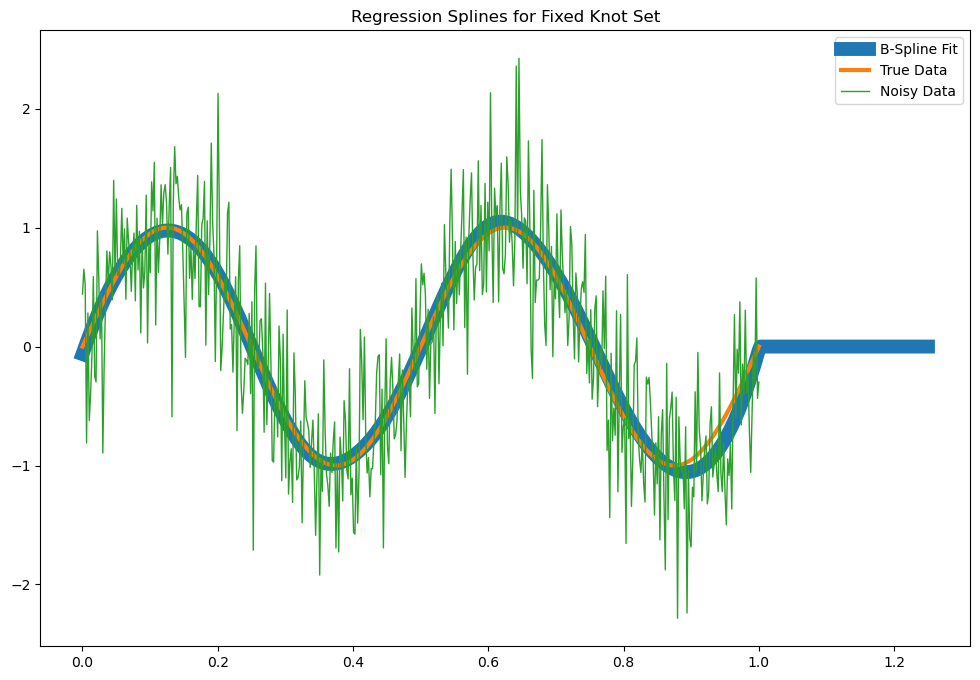

In [13]:
adjusted_x=np.linspace(0,1.25,500)


fig,ax=plt.subplots(1,1,figsize=(12,8))

ax.set_title('Regression Splines for Fixed Knot Set')

ax.plot(adjusted_x,spline.estimate(adjusted_x), label='B-Spline Fit',lw=10)

ax.plot(x,y, label='True Data',lw=3)
ax.plot(x,noisy, label='Noisy Data',lw=1)

ax.legend()


### Differentiation for Splines represented within the B-Spline Basis Functions



In [14]:
import sys
sys.path.append("../../estimators/splines/helpers/")
from spline_derivative import compute_spline_derivative

In [16]:
spline_prime=compute_spline_derivative(spline,degree=1)


Known as De-boors algorithm, this is a recursive algorithm for evaluating the derivative of a B-Spline Basis Function. The algorithm is defined as

$$B_{i,k}'(x) = \frac{k}{x_{i+k}-x_i}B_{i,k-1}'(x) + \frac{k}{x_{i+k+1}-x_{i+1}}B_{i+1,k-1}'(x)$$

where $x_i$ and $x_{i+1}$ are the knots of the spline. The $B_{i,k}'$ are called B-Spline Basis Functions of degree $k$.

A p-degree spline will have a p-1 degree derivative and two less knots on the boundary

In [19]:
assert spline_prime.degree==2

In [20]:
spline_prime.basis.gamma

array([0.        , 0.        , 0.        , 0.2       , 0.26666667,
       0.33333333, 0.4       , 0.46666667, 0.53333333, 0.6       ,
       0.66666667, 0.73333333, 0.8       , 1.        , 1.        ,
       1.        ])

In [21]:
from scipy.interpolate import make_lsq_spline

scipy_spline=make_lsq_spline(x,noisy,t=spline.basis.gamma,k=3)

scipy_derivative=scipy_spline.derivative()

scipy_double_derivative=scipy_spline.derivative(2)


In [22]:
assert np.allclose(spline_prime.basis.gamma,scipy_derivative.t)


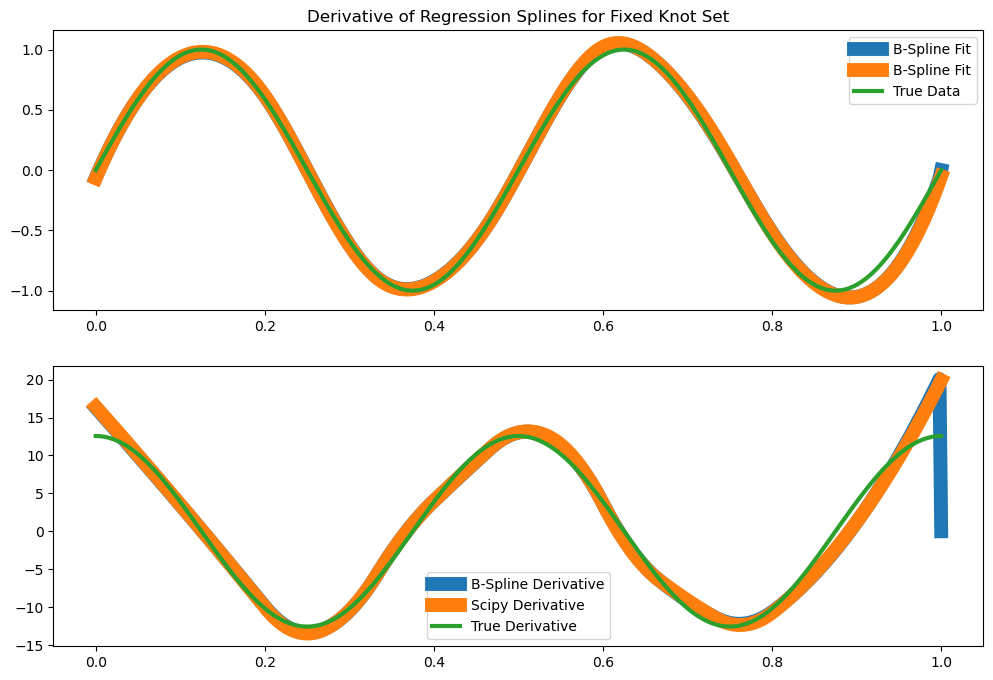

In [24]:
fig,ax=plt.subplots(2,1,figsize=(12,8))

ax[0].set_title('Derivative of Regression Splines for Fixed Knot Set')

ax[0].plot(x,spline.y_hat, label='B-Spline Fit',lw=10)
ax[0].plot(x,scipy_spline(x), label='B-Spline Fit',lw=10)
ax[0].plot(x,y, label='True Data',lw=3)
ax[0].legend()

ax[1].plot(x,spline_prime.y, label='B-Spline Derivative',lw=10)
ax[1].plot(x,scipy_derivative(x), label='Scipy Derivative',lw=10)

ax[1].plot(x,derivative, label='True Derivative',lw=3)
ax[1].legend()


### Higher Order Derivatives can be computed recursively

Note if the true function isn't piecewise polynomial; higher derivatives will have a larger error. This is due to the fact that the B-Spline Basis Functions are piecewise polynomial while the true function need not to respect

In [25]:
spline_double_prime=compute_spline_derivative(spline=spline, degree=2)

In [26]:
spline_double_prime.degree

1

In [27]:
assert np.allclose(spline_double_prime.basis.gamma,scipy_double_derivative.t)

### Comparison against Scipy


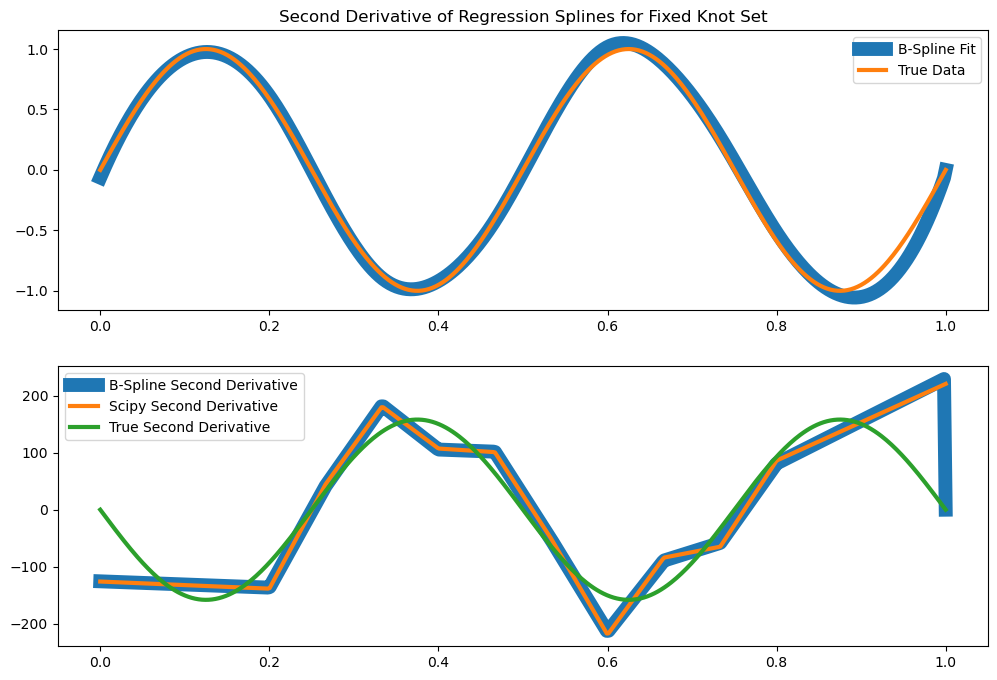

In [29]:
fig,ax=plt.subplots(2,1,figsize=(12,8))

ax[0].set_title('Second Derivative of Regression Splines for Fixed Knot Set')

ax[0].plot(x,spline.y_hat, label='B-Spline Fit',lw=10)

ax[0].plot(x,y, label='True Data',lw=3)
ax[0].legend()

ax[1].plot(x,spline_double_prime.y_hat, label='B-Spline Second Derivative',lw=10)
ax[1].plot(x,scipy_double_derivative(x), label='Scipy Second Derivative',lw=3)

ax[1].plot(x,double_derivative, label='True Second Derivative',lw=3)
ax[1].legend()



In [31]:
assert spline_double_prime.degree==1

In [32]:
spline_double_prime.basis.gamma

array([0.        , 0.        , 0.2       , 0.26666667, 0.33333333,
       0.4       , 0.46666667, 0.53333333, 0.6       , 0.66666667,
       0.73333333, 0.8       , 1.        , 1.        ])

### Integration for Splines represented within the B-Spline Basis Functions